# Running GBC on the dataset.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier as abclf
from sklearn.metrics import confusion_matrix
from pcfm import plot_confusion_matrix
from pfimp import plot_feature_importance
from sklearn.model_selection import StratifiedKFold
from threeinone import cfm3in1, fimp3in1
from fpr_area import givemis,areas,erts_plot,thres

In [2]:
df = pd.read_csv('all_in_one.csv')
df = pd.DataFrame.as_matrix(df)
# It seems there are NaNs in the dataset.. 
# And all of them are in column 3. The one with log(.)
df = df[~np.isnan(df).any(axis=1)]
X = df[:,0:6] # Our feature matrix
y = np.array(df[:,-1],dtype=np.int) # Our truth labels
idx = np.array(df[:,6],dtype=np.int) # our ID
clname = ['RFI','PULSAR']
np.set_printoptions(precision=2)

In [3]:
np.unique(y,return_counts=True)

(array([0, 1]), array([87680,  1192]))

## No oversampling

In [4]:
kf = StratifiedKFold(3,shuffle=True,random_state=340)
conf_mats = [] # list to hold the confusion matrices
fimpl = [] # list to hold the feature importances
predprobs = [] # predicted probabilities

In [5]:
# Hyperparameters
num_trees = 100
random_seed = 9876
num_obj_leaf_node = 3
max_depth = 5
min_samples_leaf = 1

In [6]:
rc = 0
conf_mats = [] # list to hold the confusion matrices
plt.figure()
for tr,te in kf.split(X,y):
     print "[",rc,'] Iteration...Starting'
     xtrain, xtest = X[tr],X[te]
     ytrain, ytest,ytid = y[tr],y[te],idx[te]
     adclf = abclf(n_estimators=250,max_depth=5,min_samples_leaf=2,learning_rate=1e-1,random_state=1234)
     print "[``] Fitting"
     adclf.fit(xtrain,ytrain) # My fitting
     ypredict = adclf.predict(xtest)
     conf_mats.append(confusion_matrix(ytest,ypredict))
     imp = adclf.feature_importances_
     fimpl.append(imp)
     ypp = adclf.predict_proba(xtest)
     tdf = np.column_stack((ytest,ypredict,ypp[:,0],ypp[:,1]))
     if rc == 0:
        outdf = tdf
     else:
        outdf = np.concatenate((outdf,tdf),axis=0)
     print "[",rc,'] Iteration...Done'
     rc = rc + 1

[ 0 ] Iteration...Starting
[``] Fitting
[ 0 ] Iteration...Done
[ 1 ] Iteration...Starting
[``] Fitting
[ 1 ] Iteration...Done
[ 2 ] Iteration...Starting
[``] Fitting
[ 2 ] Iteration...Done


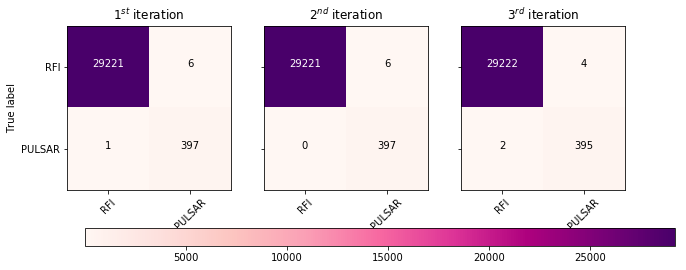

In [7]:
cfm3in1(conf_mats,clname)
plt.show()

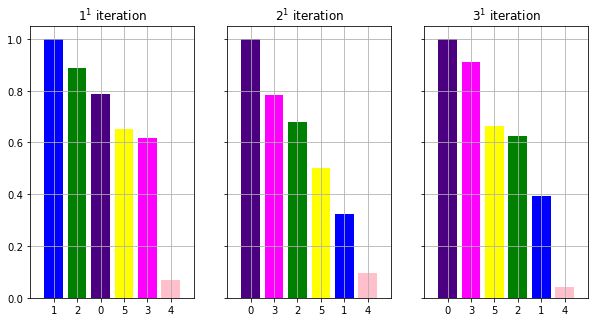

In [8]:
fimp3in1(fimpl)
plt.show()

## SMOTE
SMOTE is a way to learn imbalanced or highly skewed datasets. 
We specify a ratio of minority samples(pulsars) and majority samples(RFIs) and SMOTE using K-means and interpolation, generates new samples of the minority class until the desired ratio is achieved. 

After getting sX,sy afterever follows is the same. Fitting and plotting just with a minor change that I've prepended 'sm' to each variable to differentiate.

In [9]:
from imblearn.over_sampling import SMOTE
# this is one additional function I'll be needing
sme = SMOTE(ratio=0.5,random_state=1234) # please refer the above section for param definitions.
smX,smy = sme.fit_sample(X,y) # transforming 

In [10]:
smkf = StratifiedKFold(3,shuffle=True,random_state=340)
smconf_mats = [] # list to hold the confusion matrices
smfimpl = [] # list to hold the feature importances
smpredprobs = [] # predicted probabilities

In [11]:
rc = 0
smconf_mats = [] # list to hold the confusion matrices
plt.figure()
for tr,te in kf.split(smX,smy):
     print "[",rc,'] Iteration...Starting'
     xtrain, xtest = smX[tr],smX[te]
     ytrain, ytest= smy[tr],smy[te]
     smadclf = abclf(n_estimators=300,max_depth=5,min_samples_leaf=3,learning_rate=1e-2,random_state=1234)
     print "[``] Fitting"
     smadclf.fit(xtrain,ytrain) # My fitting
     ypredict = smadclf.predict(xtest)
     smconf_mats.append(confusion_matrix(ytest,ypredict))
     imp = smadclf.feature_importances_
     smfimpl.append(imp)
     ypp = smadclf.predict_proba(xtest)
     tdf = np.column_stack((ytest,ypredict,ypp[:,0],ypp[:,1]))
     if rc == 0:
        smoutdf = tdf
     else:
        smoutdf = np.concatenate((smoutdf,tdf),axis=0)
     print "[",rc,'] Iteration...Done'
     rc = rc + 1

[ 0 ] Iteration...Starting
[``] Fitting
[ 0 ] Iteration...Done
[ 1 ] Iteration...Starting
[``] Fitting
[ 1 ] Iteration...Done
[ 2 ] Iteration...Starting
[``] Fitting
[ 2 ] Iteration...Done


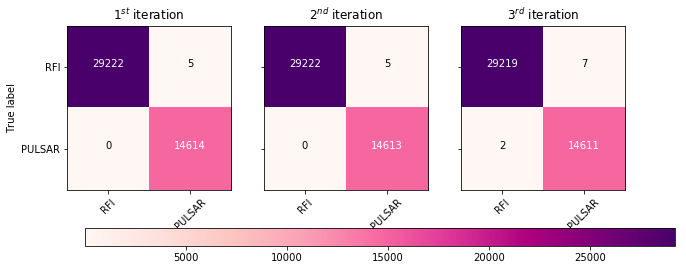

In [12]:
cfm3in1(smconf_mats,clname)
plt.show()

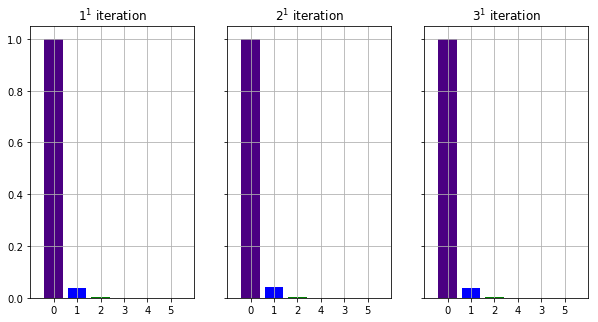

In [13]:
fimp3in1(smfimpl)
plt.show()

## FPR Analysis

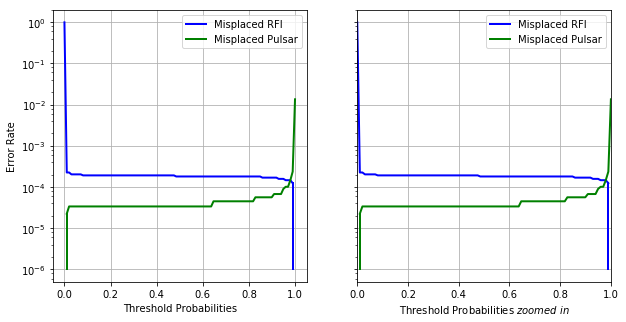

In [14]:
erts_plot(givemis(outdf,0.0,1.0),givemis(outdf,0.0,1.0),[0.0,1.0])
plt.show()

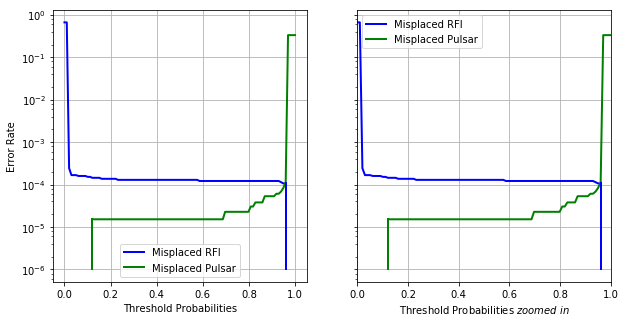

In [15]:
erts_plot(givemis(smoutdf,0.0,1.0),givemis(smoutdf,0.0,1.0),[0.0,1.0])
plt.show()

In [27]:
thres(0.4,outdf)

FPR: 0.000191286344405
FNR: 3.37564137186e-05
Recall: 0.997483221477
Precision: 0.985903814262


In [28]:
thres(0.8,outdf)

FPR: 0.000180034206499
FNR: 4.50085516248e-05
Recall: 0.996644295302
Precision: 0.986710963455


In [29]:
thres(0.97,outdf)

FPR: 0.000146277792781
FNR: 0.000101269241156
Recall: 0.99244966443
Precision: 0.989130434783


In [30]:
thres(0.4,smoutdf)

FPR: 0.000129257907543
FNR: 1.52068126521e-05
Recall: 0.999954379562
Precision: 0.99961235891


In [31]:
thres(0.9,smoutdf)

FPR: 0.000121654501217
FNR: 5.32238442822e-05
Recall: 0.999840328467
Precision: 0.999635111405


In [33]:
thres(0.96,smoutdf)

FPR: 0.000106447688564
FNR: 0.000114051094891
Recall: 0.999657846715
Precision: 0.99968064965


## Metric scores

In [22]:
from sklearn.metrics import *

In [23]:
print "The recall score is    {:0.4f}".format(recall_score(outdf[:,0],outdf[:,1]))
print "The precision score is {:0.4f}".format(precision_score(outdf[:,0],outdf[:,1]))
print "The accuracy is        {:0.4f}".format(accuracy_score(outdf[:,0],outdf[:,1]))
print "The f1 score is        {:0.4f}".format(f1_score(outdf[:,0],outdf[:,1]))
print "The logloss score is   {:0.4f}".format(log_loss(outdf[:,0],outdf[:,1]))
print "The MCC is             {:0.4f}".format(matthews_corrcoef(outdf[:,0],outdf[:,1]))

The recall score is    0.9975
The precision score is 0.9867
The accuracy is        0.9998
The f1 score is        0.9921
The logloss score is   0.0074
The MCC is             0.9920


In [24]:
print "The recall score is    {:f}".format(recall_score(smoutdf[:,0],smoutdf[:,1]))
print "The precision score is {:0.4f}".format(precision_score(smoutdf[:,0],smoutdf[:,1]))
print "The accuracy is        {:0.4f}".format(accuracy_score(smoutdf[:,0],smoutdf[:,1]))
print "The f1 score is        {:0.4f}".format(f1_score(smoutdf[:,0],smoutdf[:,1]))
print "The logloss score is   {:0.4f}".format(log_loss(smoutdf[:,0],smoutdf[:,1]))
print "The MCC is             {:0.4f}".format(matthews_corrcoef(smoutdf[:,0],smoutdf[:,1]))

The recall score is    0.999954
The precision score is 0.9996
The accuracy is        0.9999
The f1 score is        0.9998
The logloss score is   0.0050
The MCC is             0.9997


## Area analysis

In [25]:
areas(givemis(outdf,0.0,1.0))

mmint 4.26312059897e-05
mis1 0.00433433678156
mis2 0.000100312620004


In [26]:
areas(givemis(smoutdf,0.0,1.0))

mmint 1.99685418664e-05
mis1 0.0102254166769
mis2 0.0118043267222
